<a href="https://colab.research.google.com/github/garthajon/QuantFinanceIntro/blob/main/CallOptionPriceChangeProjection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install yfinance


[*********************100%***********************]  1 of 1 completed
<ipython-input-18-880879774bb4>:51: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(current_price)


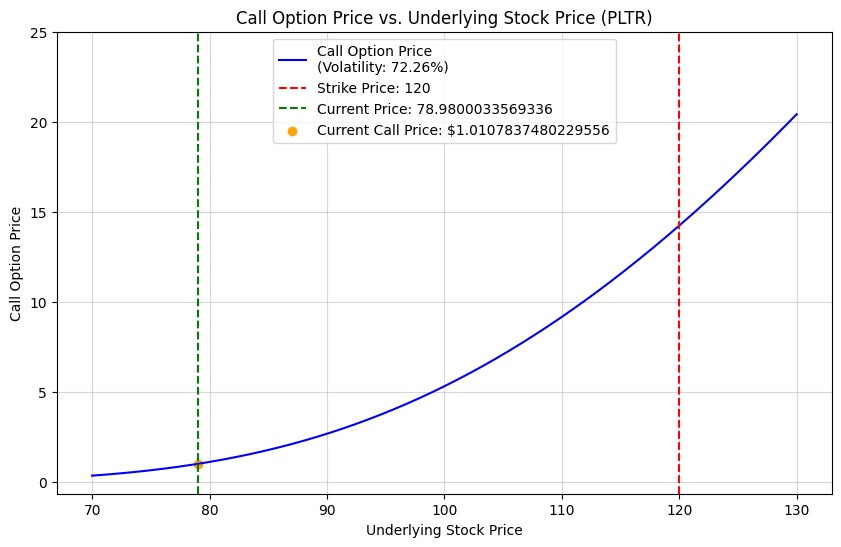

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

def calculate_annualized_volatility(ticker, days=60):
    """
    Calculate the annualized volatility from historical stock prices.
    ticker: Stock ticker symbol (e.g., 'TSLA')
    days: Number of past trading days to consider for volatility calculation
    """
    # Fetch historical stock data from Yahoo Finance
    stock_data = yf.download(ticker, period=f"{days + 1}d", interval="1d")

    # Calculate daily log returns
    stock_data['Log Returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

    # Calculate standard deviation of daily log returns
    daily_volatility = stock_data['Log Returns'].std()

    # Annualize the volatility
    annualized_volatility = daily_volatility * np.sqrt(252)  # Assuming 252 trading days in a year
    return annualized_volatility, stock_data['Close'].iloc[-1]  # Return volatility and last closing price

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price of a call option.
    S: Current stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free rate (as a decimal)
    sigma: Volatility (standard deviation of returns)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def plot_call_price_change_with_time(ticker, S_min, S_max, K, T_days, r):
    """
    Plot the change in call option price over a range of stock prices using actual annualized volatility.
    ticker: Stock ticker symbol (e.g., 'TSLA')
    S_min: Minimum stock price (e.g., current price)
    S_max: Maximum projected stock price
    K: Strike price
    T_days: Time to maturity in days
    r: Risk-free rate (as a decimal)
    """
    # Calculate annualized volatility and get current stock price
    sigma, current_price = calculate_annualized_volatility(ticker)
    current_price = float(current_price)
    # Convert time to maturity to a fraction of a year
    T = T_days / 365.0

    # Generate a range of stock prices
    stock_prices = np.linspace(S_min, S_max, 500)

    # Calculate the call option prices for each stock price
    call_prices = [black_scholes_call(S, K, T, r, sigma) for S in stock_prices]

    # Calculate the current call option price
    current_call_price = black_scholes_call(current_price, K, T, r, sigma)
    current_call_price = float(current_call_price)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices, call_prices, label=f"Call Option Price\n(Volatility: {sigma:.2%})", color="blue")
    plt.axvline(K, color="red", linestyle="--", label=f"Strike Price: {K}")
    plt.axvline(current_price, color="green", linestyle="--", label=f"Current Price: {current_price}")
    plt.scatter(current_price, current_call_price, color="orange", label=f"Current Call Price: ${current_call_price}")
    plt.title(f"Call Option Price vs. Underlying Stock Price ({ticker})")
    plt.xlabel("Underlying Stock Price")
    plt.ylabel("Call Option Price")
    # Set Y-axis scale to increments of 2
    plt.yticks(np.arange(0, max(call_prices) + 5, 5))

    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

# Parameters
ticker = "PLTR"  # Stock ticker symbol
S_min = 70      # Minimum current stock price (e.g., TSLA)
S_max = 130      # Maximum projected stock price
K = 120          # Strike price
T_days = 60      # Time to maturity in days
r = 0.03         # Risk-free interest rate (e.g., 3%)

# Plot the scenario
plot_call_price_change_with_time(ticker, S_min, S_max, K, T_days, r)
